<a href="https://colab.research.google.com/github/MehaRima/2sxc-content-app/blob/master/tracker_w5_aml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

In this programming assignment you will optimize a simple tracking system using Bayesian optimization with Gaussian processes. The same method can be used for more complex systems optimization. For an example, the ATLAS tracking system:

<img src="pic/tracks.png" width="700" />
https://twiki.cern.ch/twiki/bin/view/AtlasPublic/EventDisplayRun2Collisions

# New Section


In [74]:
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
!pip install tensorflow==1.2

# For the latest nightly build:
!pip install tf-nightly
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive
!apt-get -qq install python-cartopy python3-cartopy
import cartopy
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

Name: tensorflow
Version: 1.2.0
Summary: TensorFlow helps the tensors flow
Home-page: http://tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: html5lib, numpy, markdown, six, backports.weakref, bleach, wheel, protobuf, werkzeug
Required-by: fancyimpute
  Using cached https://files.pythonhosted.org/packages/97/ae/0b08f53498417914f2274cc3b5576d2b83179b0cbb209457d0fde0152174/tensorflow-2.3.0-cp36-cp36m-manylinux2010_x86_64.whl
  Found existing installation: tensorflow 1.2.0
    Uninstalling tensorflow-1.2.0:
      Successfully uninstalled tensorflow-1.2.0
  Using cached https://files.pythonhosted.org/packages/5e/55/7995cc1e9e60fa37ea90e6777d832e75026fde5c6109215d892aaff2e9b7/tensorflow-1.2.0-cp36-cp36m-manylinux1_x86_64.whl
Processing /root/.cache/pip/wheels/b6/52/17/f0af18e3e0ec6fa60b361ffed15b4c3468f6f3bcdb87fbe079/Markdown-2.2.0-cp36-none-any.whl
ERROR: tensorboard 2.3.0 has requirement

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils

# Geometry generation

Our simple tracking system consists of 4 layers of straw tubes, which detects particles fly through them. Each layer has 200 tubes. The system is parametrized by six adjustable parameters: $y_{1}$, $y_{2}$, $y_{3}$, $z_{1}$, $z_{2}$, $z_{3}$. These parameters describe shifts between the layers as it is show in the figure: 

<img src="pic/system.png" alt="Drawing" style="width: 700px;">

In this notebook we suppose that the radius $R$ of tubes is 1 cm and the distance between tubes in one layer (pitch) is 4 cm. We take these values as constants and will not change them.  Also z-value must be more than 2, otherwise these tubes will intersect. It's wrong.

For an example, lets select values for the layers shifts.

In [76]:
# CONSTANT PARAMETERS
R = 1. # cm
pitch = 4.0 #cm 

# ADJUSTABLE PARAMETERS
y1 = 0.0
y2 = 1.0
y3 = 0.0
z1 = 1.0
#z2 = 4.0
z2 = 1.0
z3 = 0.0

Using these parameter values we generate $Z$ and $Y$ coordinates of tubes in the tracking system.

In [77]:
tr = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
Z, Y = tr.create_geometry()

Now display several tubes of the generated geometry.

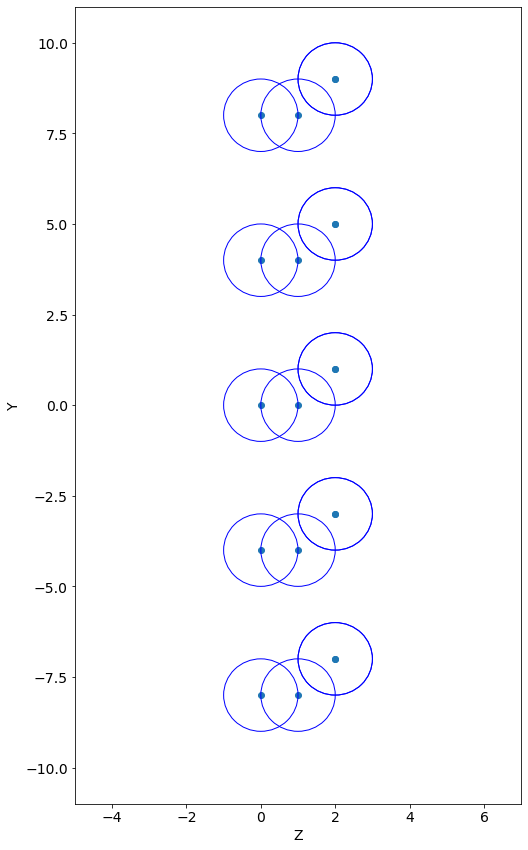

In [78]:
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)

# Tracks generation

Lets generate several tracks of particles fly in the tracking system. We consider straight tracks with equation: 

$$
y = kz + b
$$

where $z, y$ are coordinates of the track, $k$ is slope of the track and $b$ is the y intercept.

Track parameters are generated from the following distributions:

$$
b \in U(b_{min}, b_{max})\\
k = tan(\alpha), \alpha \in N(\mu_{\alpha}, \sigma_{\alpha})
$$

where $U$ is uniform distribution and $N$ is normal distribution.

In [79]:
N_tracks = 5000
t = utils.Tracks(b_min=-100, b_max=100, alpha_mean=0, alpha_std=0.2)
tracks = t.generate(N_tracks)

Display the tubes geometry with the generated tracks.

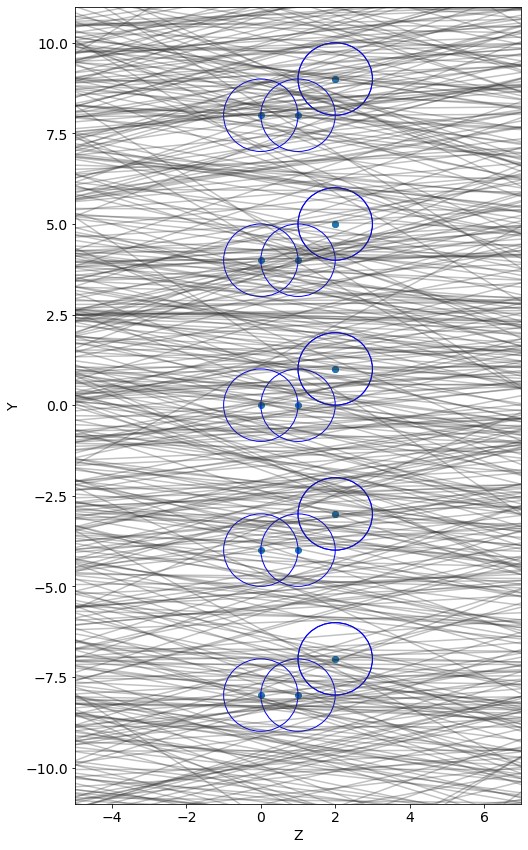

In [80]:
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)
utils.tracks_display(tracks, Z)

# Target metric

For a given geaometry of the tracking system we will calculate the ratio of tracks with at least 2 hits to the total number of tracks:

$$Score = \frac{N\_tracks_{n\_hits \ge 2}}{N\_tracks}$$

The higher score, the better.

In [81]:
score = utils.get_score(Z, Y, tracks, R)
print(score)

0.7406


# Optimization

In this programming assignment you need to find parameters of geometry of the tracking system that provides the highest **score** value. However, we propose to solve a minimization problem. So you need to minimize **1-score** value. This is an objective function of the optimization


Lets define ranges of the adjustable parameters of the system.

In [82]:
# You can change these values
y1_min, y1_max = [0, 2]
y2_min, y2_max = [0, 3]
y3_min, y3_max = [0, 2]
z1_min, z1_max = [2, 3]
z2_min, z2_max = [0, 2]
z3_min, z3_max = [2, 4]

And generate tracks used during the optimization.

In [83]:
t = utils.Tracks(-100, 100, 0, 0.2)
tracks = t.generate(1000)

Define the objective function of the optimization

In [84]:
def objective(x):
    
    R, pitch, y1, y2, y3, z1, z2, z3 = x
    Z, Y = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3).create_geometry()
    val = utils.get_score(Z, Y, tracks, R)
    
    return 1. - val # the smaller, the better.

## Grid search

Firstly, lets try to solve the optimization problem using grid search.

TASK: find optimal parameters of the tracking system using grid search.

In [85]:
%%time

# Number of unique values for each of the adjustable parameters.
n_points = 2

# Define grid of the parameters
y1_grid = np.linspace(y1_min, y2_max, n_points)
y2_grid = np.linspace(y2_min, y2_max, n_points)
y3_grid = np.linspace(y3_min, y3_max, n_points)
z1_grid = np.linspace(z1_min, z1_max, n_points)
z2_grid = np.linspace(z2_min, z2_max, n_points)
z3_grid = np.linspace(z3_min, z3_max, n_points)

# Define list to store the optimization results
min_objective_values = []
params_for_min_objective_values = []

is_first = True

# Loop on the grid
for y1 in y1_grid:
    for y2 in y2_grid:
        for y3 in y3_grid:
            for z1 in z1_grid:
                for z2 in z2_grid:
                    for z3 in z3_grid:

                        # Calculate the objective function value for a grid node
                        x = [R, pitch, y1, y2, y3, z1, z2, z3]
                        val = objective(x)

                        if is_first:
                            min_objective_values.append(val)
                            params_for_min_objective_values.append(tuple(x))
                            is_first = False
                        elif val < min_objective_values[-1]:
                            min_objective_values.append(val)
                            params_for_min_objective_values.append(tuple(x))
                        else:
                            min_objective_values.append(min_objective_values[-1])
                            params_for_min_objective_values.append(params_for_min_objective_values[-1])

CPU times: user 1.22 s, sys: 0 ns, total: 1.22 s
Wall time: 1.22 s


Plot the optimization curve

Objective optimum =  0.22999999999999998


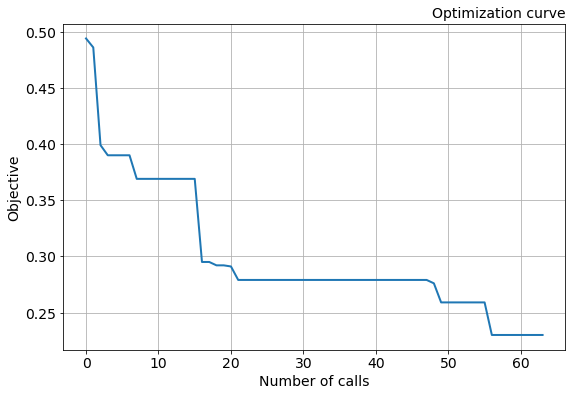

In [86]:
print("Objective optimum = ", min_objective_values[-1])
utils.plot_objective(min_objective_values)

In [87]:
(R, pitch, y1, y2, y3, z1, z2, z3) = params_for_min_objective_values[-1]
print("Optimal parameters: ")
print("y1 = ", y1)
print("y2 = ", y2)
print("y3 = ", y3)
print("z1 = ", z1)
print("z2 = ", z2)
print("z3 = ", z3)

Optimal parameters: 
y1 =  3.0
y2 =  3.0
y3 =  2.0
z1 =  2.0
z2 =  0.0
z3 =  2.0


Display the optimal tracking system geometry.

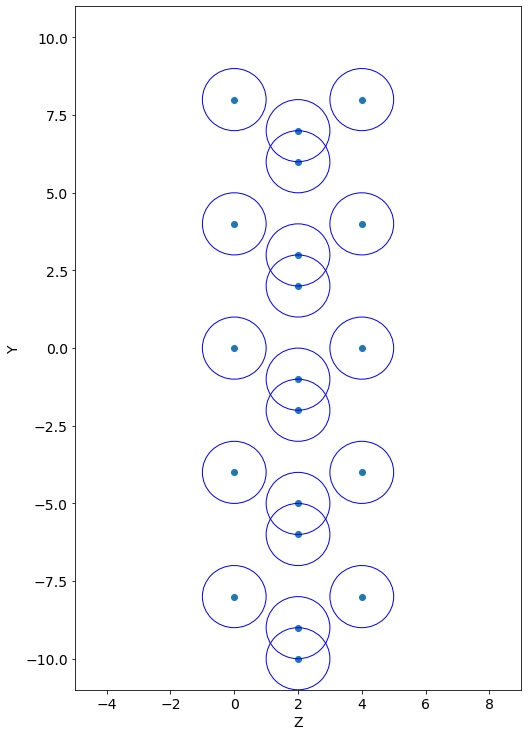

In [88]:
Z, Y = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3).create_geometry()
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)

## Random search

Now, lets modify grid search. For this we will generate random points in the parameter space instead of the grid.

TASK: find optimal parameters of the tracking system using random search.

In [89]:
%%time

# Number of random point to generate.
n_points = 100

# Define random values on the tracking system parameters
y1_grid = np.random.RandomState(12).uniform(y1_min, y1_max, n_points)
y2_grid = np.random.RandomState(13).uniform(y2_min, y2_max, n_points)
y3_grid = np.random.RandomState(14).uniform(y3_min, y3_max, n_points)
z1_grid = np.random.RandomState(15).uniform(z1_min, z1_max, n_points)
z2_grid = np.random.RandomState(16).uniform(z2_min, z2_max, n_points)
z3_grid = np.random.RandomState(17).uniform(z3_min, z3_max, n_points)

# Define list to store the optimization results
min_objective_values = []
params_for_min_objective_values = []

for i in range(n_points):
    
    y1 = y1_grid[i]
    y2 = y2_grid[i]
    y3 = y3_grid[i]
    z1 = z1_grid[i]
    z2 = z2_grid[i]
    z3 = z3_grid[i]
    
    # Calculate the objective function value for a grid node
    x = [R, pitch, y1, y2, y3, z1, z2, z3]
    val = objective(x)
    
    if i==0:
        min_objective_values.append(val)
        params_for_min_objective_values.append(tuple(x))
    elif val < min_objective_values[-1]:
        min_objective_values.append(val)
        params_for_min_objective_values.append(tuple(x))
    else:
        min_objective_values.append(min_objective_values[-1])
        params_for_min_objective_values.append(params_for_min_objective_values[-1])

CPU times: user 1.93 s, sys: 0 ns, total: 1.93 s
Wall time: 1.93 s


Plot the optimization curve

Objective optimum =  0.135


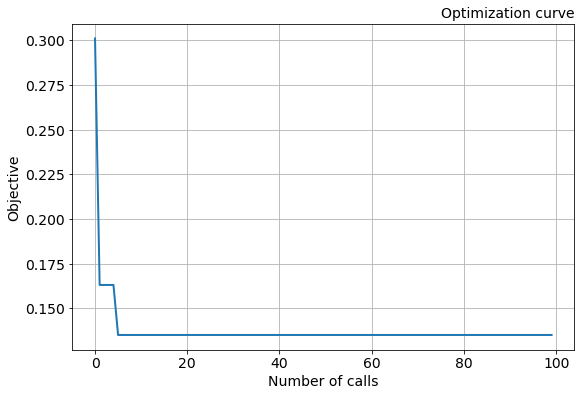

In [90]:
print("Objective optimum = ", min_objective_values[-1])
utils.plot_objective(min_objective_values)

In [91]:
(R, pitch, y1, y2, y3, z1, z2, z3) = params_for_min_objective_values[-1]
print("Optimal parameters: ")
print("y1 = ", y1)
print("y2 = ", y2)
print("y3 = ", y3)
print("z1 = ", z1)
print("z2 = ", z2)
print("z3 = ", z3)

Optimal parameters: 
y1 =  1.83749401619977
y2 =  1.3603477422519366
y3 =  1.9152074787317819
z1 =  2.530000224895425
z2 =  0.44616188338257756
z3 =  3.312667043551711


Display the optimal tracking system geometry.

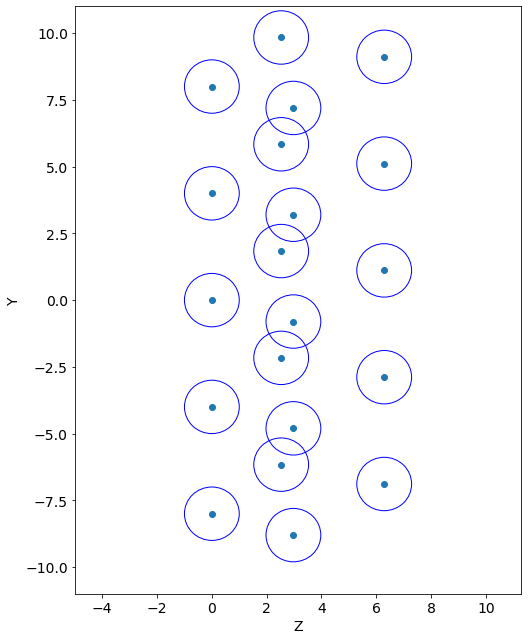

In [92]:
Z, Y = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3).create_geometry()
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)

## Bayesian optimization with Gaussian processes

At this step we will use Bayesian optimization implemented using [scikit-optimize](http://scikit-optimize.github.io/) library to find optimal tracking system geometry. During the optimization Lower Confidence Bound (LCB) acquisition function is used:

$$
LCB(x) = \mu(x) - \kappa(x) 
$$

where $\kappa$ is adjustable parameter that defines the exploration-exploitation trade-off of the optimization.

TASK: find optimal parameters of the tracking system.

In [93]:
!pip3 install scikit-optimize

from skopt import gp_minimize

# You can change these values
y1_min, y1_max = [-1, 2]
y2_min, y2_max = [-1, 2]
y3_min, y3_max = [-1, 2]
z1_min, z1_max = [2, 3]
z2_min, z2_max = [1, 4]
z3_min, z3_max = [1, 3]

kappa= 30.1
dimentions = [(R, R + 10**-6), (pitch, pitch + 10**-6), 
              (y1_min, y1_max), (y2_min, y2_max), (y3_min, y3_max),
              (z1_min, z1_max), (z2_min, z2_max), (z3_min, z3_max)]

res = gp_minimize(func=objective,                   # the function to minimize
                  dimensions=dimentions,            # the bounds on each dimension of x
                  acq_func="LCB",                   # the acquisition function
                  n_calls=120,                      # the number of evaluations of f 
                  n_random_starts=50,               # the number of random initialization points
                  noise=0.01**2,                    # the noise level (optional)
                  random_state=123,                 # the random seed
                  kappa=kappa,                      # the adjustable parameter of LCB
                  n_jobs=5)

Plot the optimization curve

Objective optimum =  0.09799999999999998


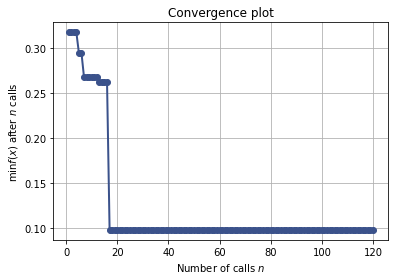

In [94]:
from skopt.plots import plot_convergence
print("Objective optimum = ", res.fun)
plot_convergence(res)

Display the optimal tracking system geometry.

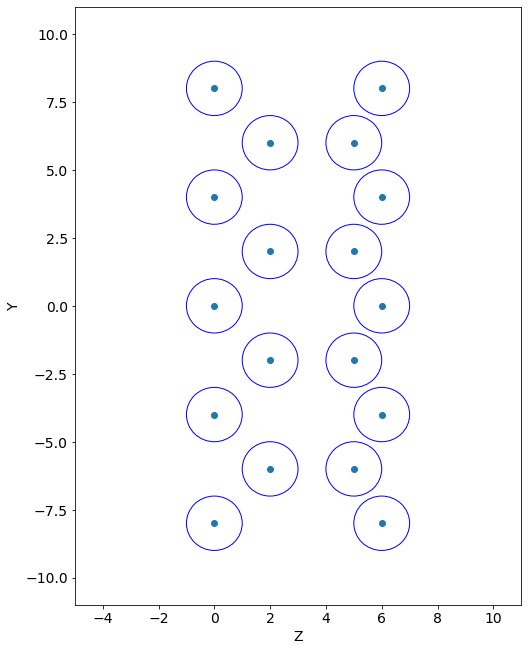

In [95]:
# get found optimal geometry
[R, pitch, y1, y2, y3, z1, z2, z3] = res.x

# plot the geometry
Z, Y = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3).create_geometry()
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)

# Submission

TASK: Using the optimization methods above try to find the best geometry of the tracking system. Then, create sumbmission file with the parameters of your geometry and submit it.

In [96]:
best = [R, pitch, y1, y2, y3, z1, z2, z3]
utils.create_solution(best, filename='submission_file.csv')

/content/submission_file.csv